# 决策树模型构建

In [68]:
#import necessary lib
from math import log
import operator
import numpy as np


class Decision_Tree_C45:
    # define entropy calculation
    def Entropy(self, train_data):
        inst_num = len(train_data)  # instances number
        label_counts = {}  # count instances of each class
        for i in range(inst_num):
            label = train_data[i][-1]  #get instance class
            if label not in label_counts.keys():
                label_counts[label] = 0
            label_counts[label] += 1  #count
        ent = 0
        for key in label_counts.keys():
            #calculate each class proportion
            prob = float(label_counts[key]) / inst_num
            ent -= prob * log(prob, 2)  # see Eq.(3.1)
        return ent

    #split data according to feature and feature value
    def split_data(self, train_data, feature_index, feature_value, feature_type):
        splitedData = []  # store splited data
        if feature_type == "D":  # for discrete feature
            for feat_vect in train_data:
                if feat_vect[feature_index] == feature_value:
                    reducedVect = []
                    #delete used discrete feature from data
                    for i in range(len(feat_vect)):
                        if i < feature_index or i > feature_index:
                            reducedVect.append(feat_vect[i])
                    splitedData.append(reducedVect)
        if feature_type == "L":  #for continous feature
            for feat_vect in train_data:
                if feat_vect[feature_index] <= feature_value:
                    splitedData.append(feat_vect)
        if feature_type == "R":  #for continous feature
            for feat_vect in train_data:
                if feat_vect[feature_index] > feature_value:
                    splitedData.append(feat_vect)
        return splitedData

    #choose best feature to split
    def choose_split_feature(self, train_data):
        feat_num = len(train_data[0]) - 1  # get available features
        base_ent = self.Entropy(train_data)
        bestInforGain = 0.0
        best_feat_index = -1
        best_feat_value = 0
        for i in range(feat_num):
            if isinstance(train_data[0][i], str):  #for discrete feature
                feat_list = [example[i] for example in train_data]
                unique_values = set(feat_list)
                newEnt = 0
                for value in unique_values:
                    sub_data = self.split_data(train_data, i, value, "D")
                    prop = float(len(sub_data)) / len(train_data)
                    newEnt += prop * self.Entropy(sub_data)  #see Eq.(3.2)
                inforgain = base_ent - newEnt
                if inforgain > bestInforGain:
                    best_feat_index = i
                    bestInforGain = inforgain
            else:  #for continous feature
                feat_list = [example[i] for example in train_data]
                unique_values = set(feat_list)
                sort_unique_values = sorted(unique_values)
                minEnt = np.inf
                for j in range(len(sort_unique_values) - 1):
                    div_value = (sort_unique_values[j] + sort_unique_values[j + 1]) / 2
                    sub_data_left = self.split_data(train_data, i, div_value, "L")
                    sub_data_right = self.split_data(train_data, i, div_value, "R")
                    prop_left = float(len(sub_data_left)) / len(train_data)
                    prop_right = float(len(sub_data_right)) / len(train_data)
                    ent = prop_left * self.Entropy(sub_data_left) + \
                          prop_right * self.Entropy(sub_data_right)  #see Eq.(3.6)
                    if ent < minEnt:
                        minEnt = ent
                        best_feat_value = div_value
                inforgain = base_ent - minEnt
                if inforgain > bestInforGain:
                    bestInforGain = inforgain
                    best_feat_index = i
            return best_feat_index, best_feat_value

    # get major class
    def get_major_class(self, classList):
        classcount = {}
        for vote in classList:
            if vote not in classcount.key():
                classcount[vote] = 0
            classcount[vote] += 1
            sortedclasscount = sorted(classcount.iteritems(), key=operator.itemgetter(1), reverse=True)
            major = sortedclasscount[0][0]
            return major

    # create decision tree
    def create_decision_tree(self, train_data, feat_names):
        classList = [example[-1] for example in train_data]
        if classList.count(classList[0]) == len(classList):  #see condition A
            return classList[0]
        if len(train_data[0]) == 1:  #see condition B
            return self.get_major_class(classList)
        if len(train_data) == 0:  #see condition C
            return
        # choose best division feature
        best_feat, best_div_value = self.choose_split_feature(train_data)
        if isinstance(train_data[0][best_feat], str):  # for discrete feature
            feat_name = feat_names[best_feat]
            tree_model = {feat_name: {}}  # generate a root node
            del (feat_names[best_feat])  # del feature used
            feat_values = [example[best_feat] for example in train_data]
            unique_feat_values = set(feat_values)
            #create a node for each value of the best feature
            for value in unique_feat_values:
                sub_feat_names = feat_names[:]
                tree_model[feat_name][value] = self.create_decision_tree(self.split_data(train_data,
                                                                                         best_feat, value, "D"),
                                                                         sub_feat_names)
        else:  #for contiunous feature
            best_feat_name = feat_names[best_feat] + "<" + str(best_div_value)
            tree_model = {best_feat_name: {}}  # generate a root node
            sub_feat_names = feat_names
            # generate left node
            tree_model[best_feat_name]["Y"] = self.create_decision_tree(self.split_data(train_data,
                                                                                        best_feat,
                                                                                        best_div_value, "L"),
                                                                        sub_feat_names)
            #generate right node
            tree_model[best_feat_name]["N"] = self.create_decision_tree(self.split_data(train_data,
                                                                                        best_feat,
                                                                                        best_div_value, "R"),
                                                                        sub_feat_names)
        return tree_model

    #define predict function
    def predict(self, tree_model, feat_names, feat_vect):
        firstStr = list(tree_model.keys())[0]  # get tree root
        lessIndex = str(firstStr).find('<')
        if lessIndex > -1:  # if root is a continous feature
            # recursively search untill leaft node
            secondDict = tree_model[firstStr]
            feat_name = str(firstStr)[:lessIndex]
            featIndex = feat_names.index(feat_name)
            div_value = float(str(firstStr)[lessIndex + 1:])
            if feat_vect[featIndex] <= div_value:
                if isinstance(secondDict["Y"], dict):
                    classLabel = self.predict(secondDict["Y"],
                                              feat_names, feat_vect)
                else:
                    classLabel = secondDict["Y"]
            else:
                if isinstance(secondDict["N"], dict):
                    classLabel = self.predict(secondDict["N"],
                                              feat_names, feat_vect)
                else:
                    classLabel = secondDict["N"]
            return classLabel
        else:  #if root is a discrete feature
            # recursively search untill leaft node
            secondDict = tree_model[firstStr]
            featIndex = feat_names.index(firstStr)
            key = feat_vect[featIndex]
            valueOfFeat = secondDict[key]
            if isinstance(valueOfFeat, dict):
                classLabel = self.predict(valueOfFeat, feat_names, feat_vect)
            else:
                classLabel = valueOfFeat
            return classLabel


# 案例实践

In [69]:

#导入数据集
#Add code here to load data from file and preprocess data
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("Client_Info.csv", encoding='gb2312')
data = np.array(data)
feat_names = ['收入','年龄','性别','历史授信额度','历史违约次数']
train, test = train_test_split(data, test_size=0.3, random_state=2022)

#Add code here to build decision tree model using Decision_Tree_C45
model = Decision_Tree_C45()
tree = model.create_decision_tree(train, feat_names)
pred_labels = []
for i in range(len(test)):
    label = model.predict(tree, feat_names, test[i])
    pred_labels.append(label)
acc = 0
for i in range(len(test)):
    if pred_labels[i] == test[i, -1]:
        acc += 1.0
print("Decision_Tree_C45 accuracy:%.3f" % (acc / len(test)))





# s-klearn包
from sklearn.tree import DecisionTreeClassifier

#Add code here to build decision tree model using sklearn
model_skl = DecisionTreeClassifier(criterion="entropy")
model_skl.fit(train[:, 0:-1], train[:, -1])
pred_labels_skl = model_skl.predict(test[:, 0:-1])
acc = 0
for i in range(len(test)):
    if pred_labels_skl[i] == test[i, -1]:
        acc += 1.0
print("Decision_Tree_SKL accuracy:%.3f" % (acc / len(test)))

Decision_Tree_C45 accuracy:0.630
Decision_Tree_SKL accuracy:0.740


In [70]:
df=pd.read_csv("Client_Info.csv", encoding='gb2312')

In [71]:
df.columns.values

array(['收入', '年龄', '性别', '历史授信额度', '历史违约次数', '是否违约'], dtype=object)

# graphviz可视化

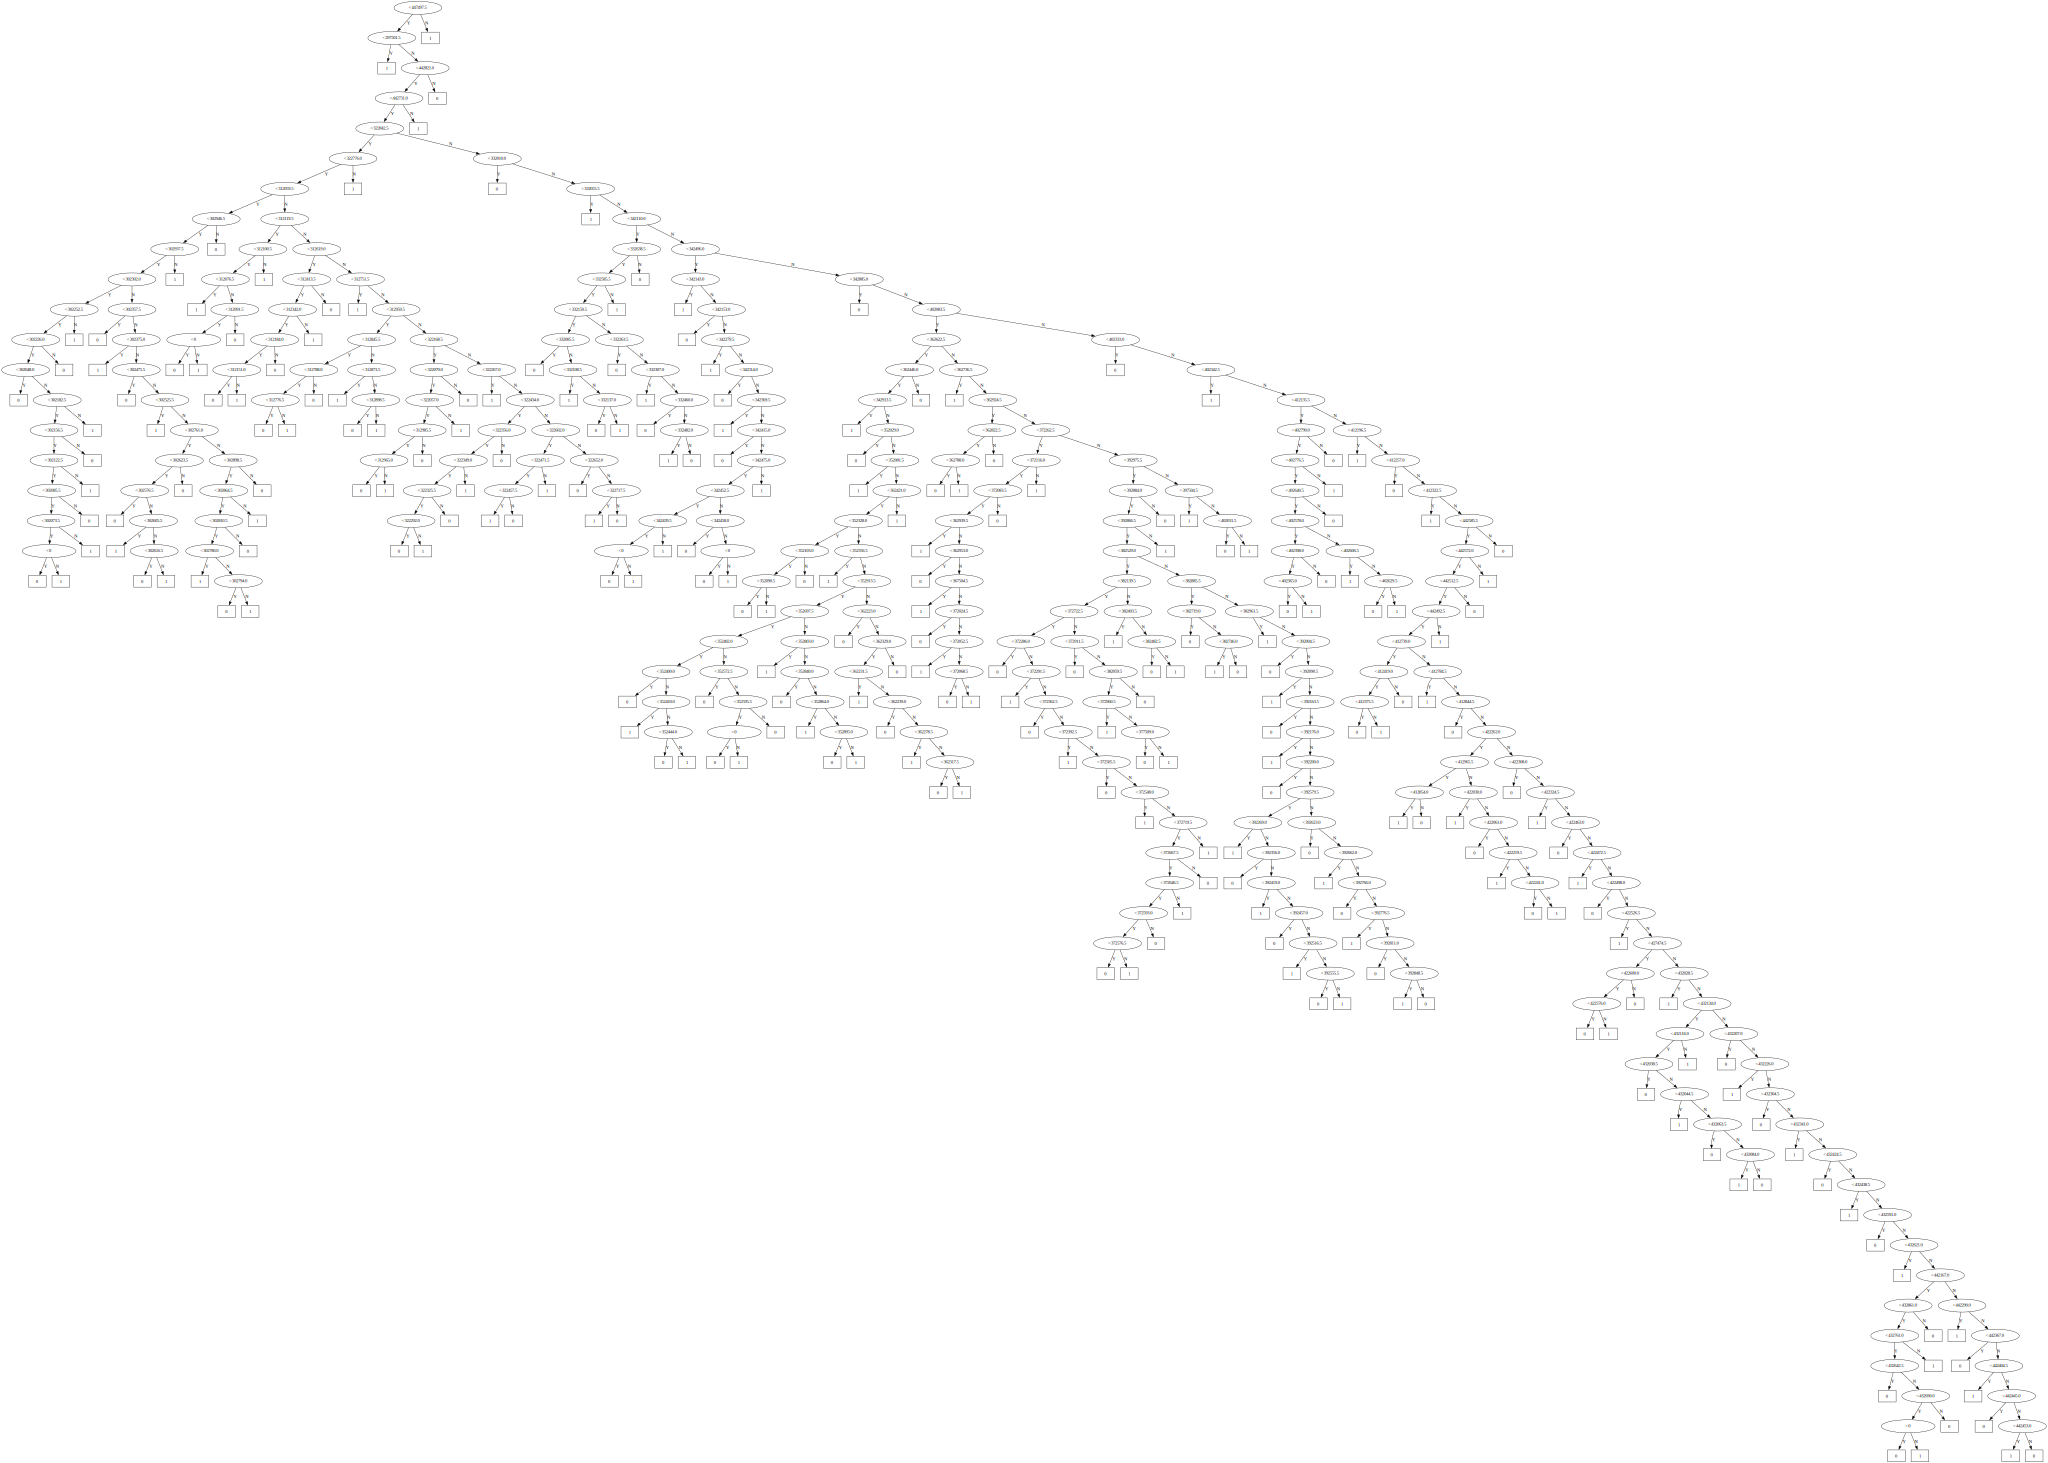

In [77]:
import graphviz
def export_to_dot(tree, feature_names, dot_string="", index=0, parent_index=None, edge_label=""):
    if index == 0:
        dot_string += "digraph Tree {\n"

    if not isinstance(tree, dict):
        # Leaf node
        label = str(tree).replace('"', '\\"')
        dot_string += f'  node{index} [label="{label}", shape=box];\n'
        if parent_index is not None:
            dot_string += f'  node{parent_index} -> node{index} [label="{edge_label}"];\n'
        return dot_string, index + 1

    # Decision node
    for key, subtree in tree.items():
        node_label = key.replace('"', '\\"')  # Escape double quotes in label
        if parent_index is not None:
            dot_string += f'  node{parent_index} -> node{index} [label="{edge_label}"];\n'
        dot_string += f'  node{index} [label="{node_label}"];\n'

        next_index = index + 1
        if isinstance(subtree, dict):
            for sub_key, sub_tree in subtree.items():
                dot_string, next_index = export_to_dot(sub_tree, feature_names, dot_string, next_index, index, sub_key)
        else:
            # Leaf node
            subtree_label = str(subtree).replace('"', '\\"')  # Escape double quotes in label
            dot_string += f'  node{next_index} [label="{subtree_label}", shape=box];\n'
            dot_string += f'  node{index} -> node{next_index} [label="{sub_key}"];\n'
            next_index += 1

        index = next_index  # Update index after processing children

    if parent_index is None:
        dot_string += "}\n"

    return dot_string, index


# 导出为DOT格式
dot_str, _ = export_to_dot(tree, feat_names)
graph = graphviz.Source(dot_str)
graph.render("decision_tree_C54")
graph

In [76]:
dot_str_skl, _ = export_to_dot(model_skl, feat_names)
graph_skl = graphviz.Source(dot_str_skl)
graph_skl

Error: <stdin>: syntax error in line 3


CalledProcessError: Command '[PosixPath('dot'), '-Kdot', '-Tsvg']' returned non-zero exit status 1. [stderr: 'Error: <stdin>: syntax error in line 3\n']

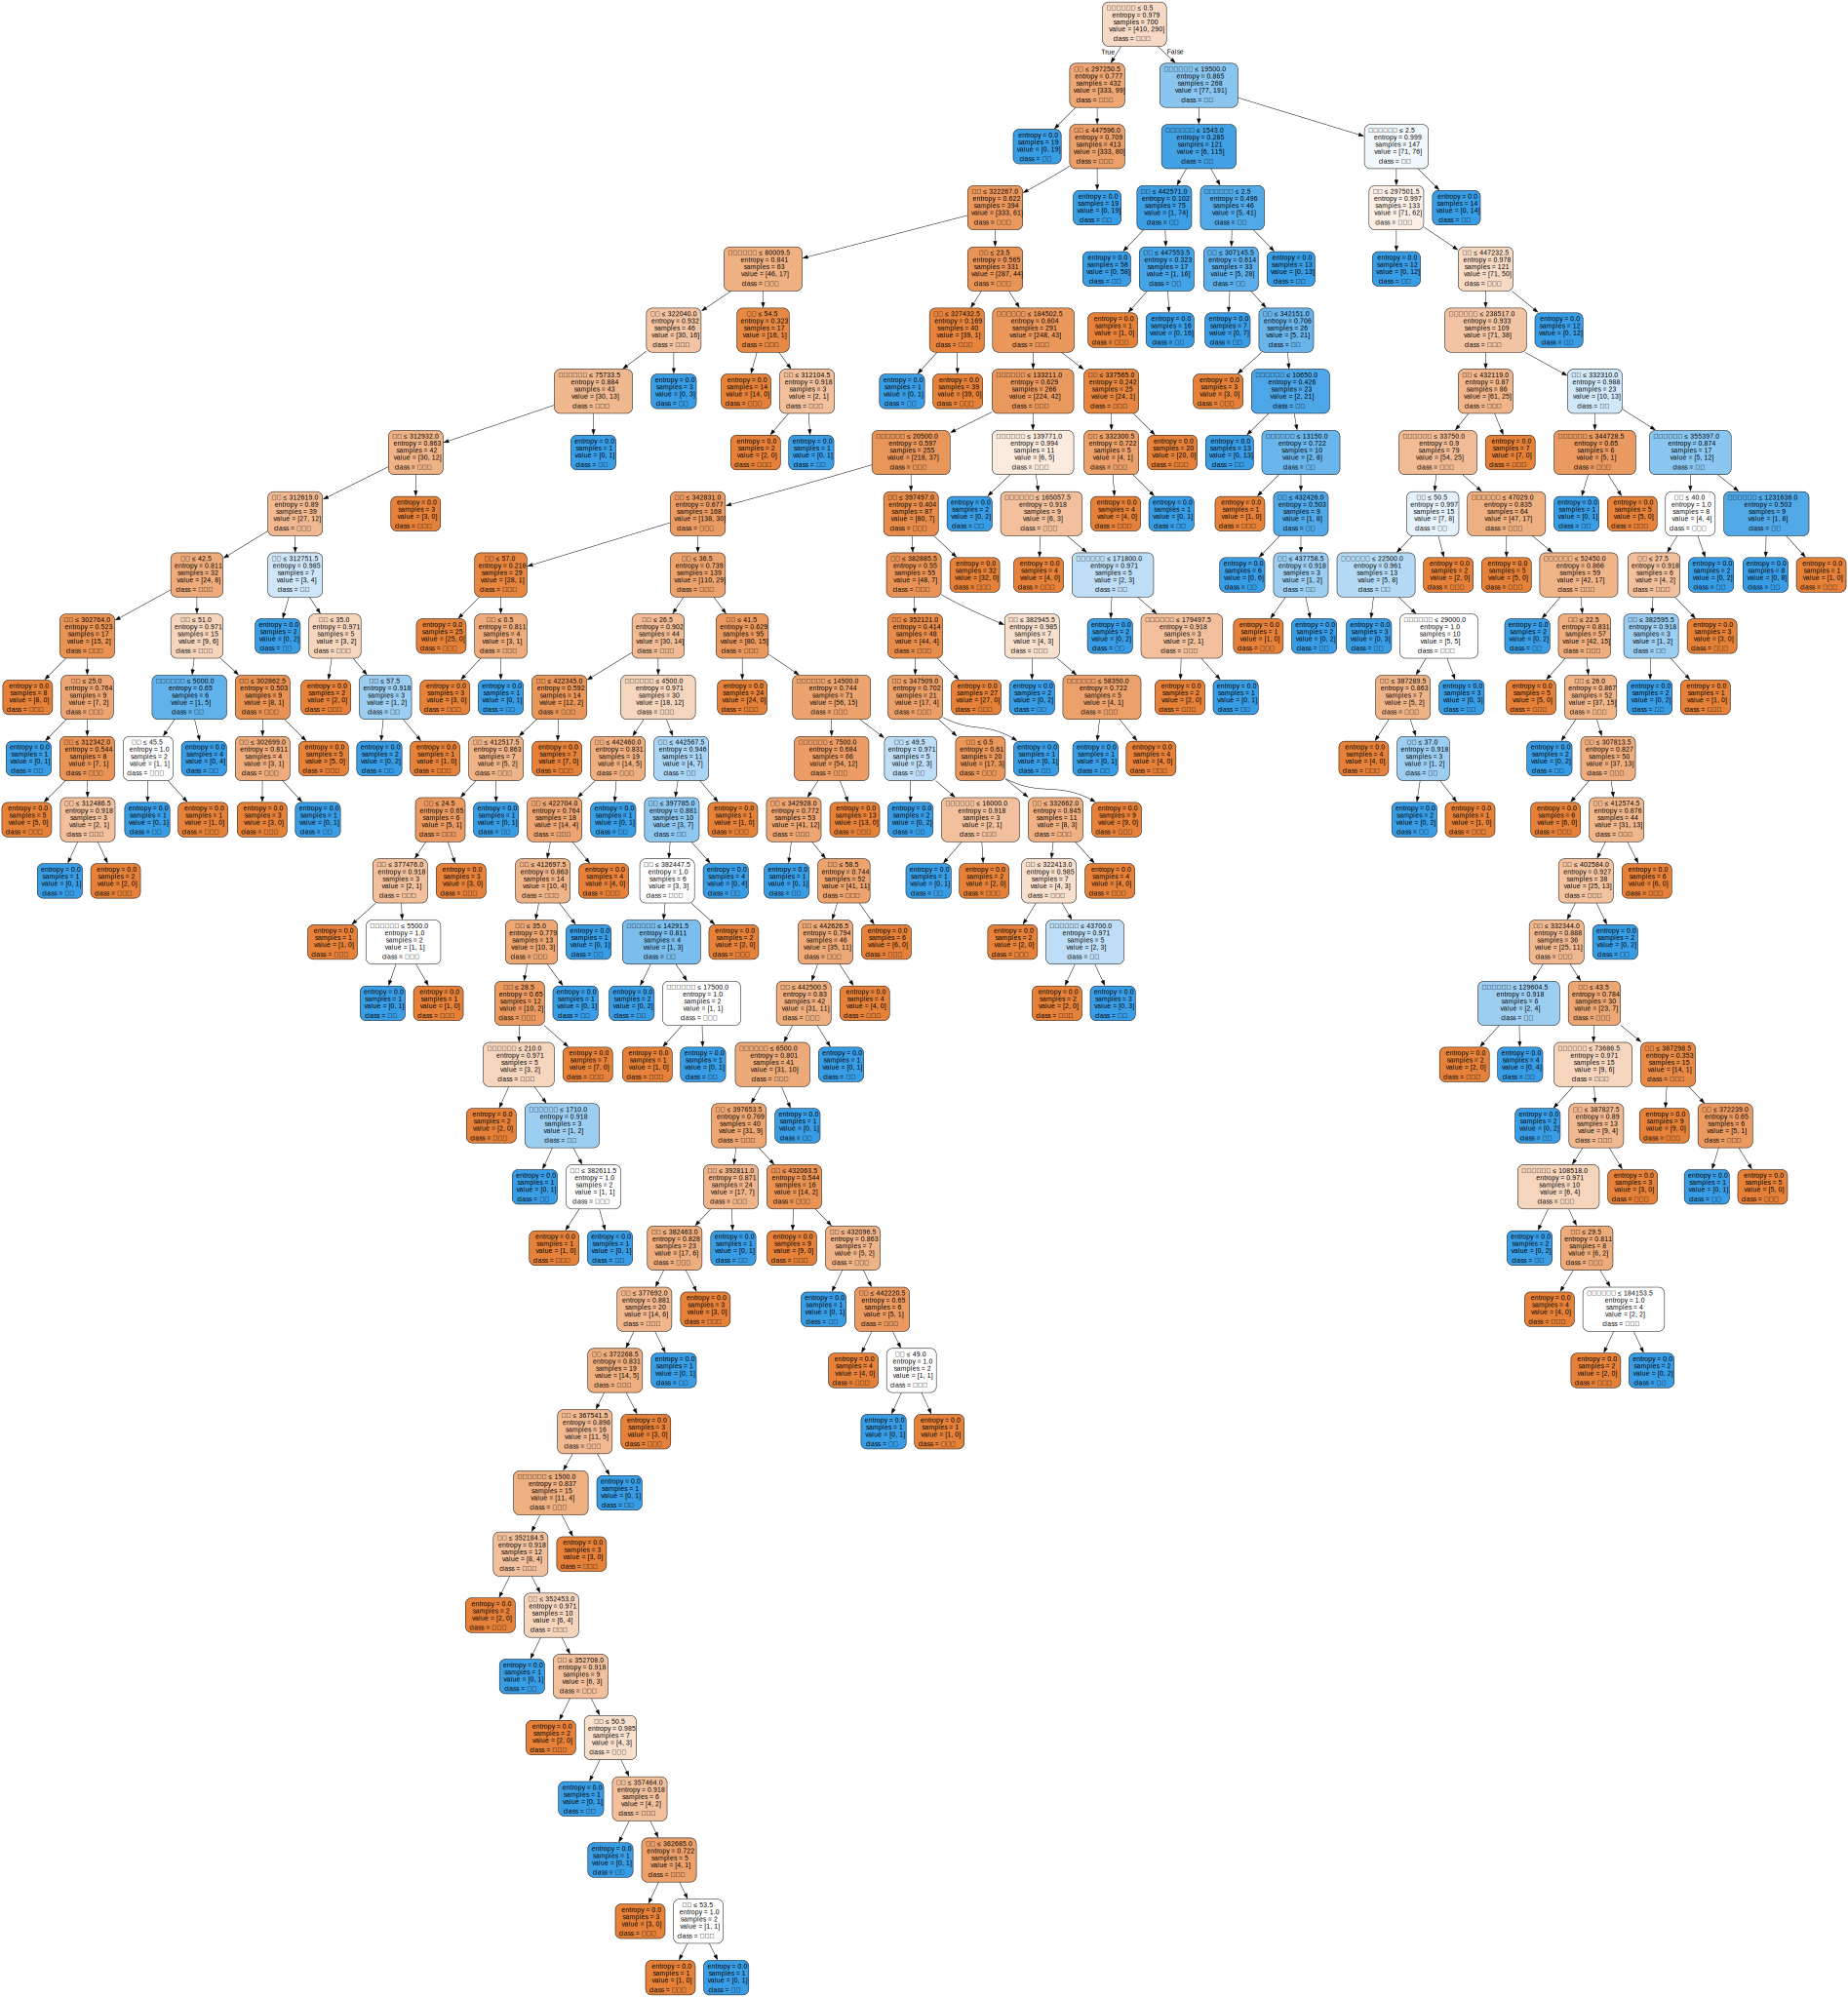

In [64]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
import graphviz

dot_data = export_graphviz(model_skl, out_file=None,
                           feature_names=feat_names, # 根据实际情况更改特征名
                           class_names=['没违约','违约'],  # 根据实际情况更改类别名
                           filled=True, rounded=True,
                           special_characters=True)

# 使用Graphviz创建图形
graph_sk = graphviz.Source(dot_data)
graph_sk.render("decision_tree")
# 显示决策树图形
graph_sk

In [10]:
# 加载数据集
iris = load_iris()
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [11]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [5]:
dot_data

'digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label=<petal width (cm) &le; 0.8<br/>gini = 0.667<br/>samples = 150<br/>value = [50, 50, 50]<br/>class = setosa>, fillcolor="#ffffff"] ;\n1 [label=<gini = 0.0<br/>samples = 50<br/>value = [50, 0, 0]<br/>class = setosa>, fillcolor="#e58139"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label=<petal width (cm) &le; 1.75<br/>gini = 0.5<br/>samples = 100<br/>value = [0, 50, 50]<br/>class = versicolor>, fillcolor="#ffffff"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n3 [label=<petal length (cm) &le; 4.95<br/>gini = 0.168<br/>samples = 54<br/>value = [0, 49, 5]<br/>class = versicolor>, fillcolor="#4de88e"] ;\n2 -> 3 ;\n4 [label=<petal width (cm) &le; 1.65<br/>gini = 0.041<br/>samples = 48<br/>value = [0, 47, 1]<br/>class = versicolor>, fillcolor="#3de684"] ;\n3 -> 4 ;\n5 [label=<gini = 0.0<br/>samples = 47<br/>val

# plot_tree可视化

[Text(0.5423716162420382, 0.9848484848484849, 'x[4] <= 0.5\nentropy = 0.979\nsamples = 700\nvalue = [410, 290]'),
 Text(0.31881966560509556, 0.9545454545454546, 'x[0] <= 297250.5\nentropy = 0.777\nsamples = 432\nvalue = [333, 99]'),
 Text(0.30608081210191085, 0.9242424242424242, 'entropy = 0.0\nsamples = 19\nvalue = [0, 19]'),
 Text(0.33155851910828027, 0.9242424242424242, 'x[0] <= 447596.0\nentropy = 0.709\nsamples = 413\nvalue = [333, 80]'),
 Text(0.31881966560509556, 0.8939393939393939, 'x[0] <= 322267.0\nentropy = 0.622\nsamples = 394\nvalue = [333, 61]'),
 Text(0.1337579617834395, 0.8636363636363636, 'x[3] <= 80009.5\nentropy = 0.841\nsamples = 63\nvalue = [46, 17]'),
 Text(0.10828025477707007, 0.8333333333333334, 'x[0] <= 322040.0\nentropy = 0.932\nsamples = 46\nvalue = [30, 16]'),
 Text(0.09554140127388536, 0.803030303030303, 'x[3] <= 75733.5\nentropy = 0.884\nsamples = 43\nvalue = [30, 13]'),
 Text(0.08280254777070063, 0.7727272727272727, 'x[1] <= 23.0\nentropy = 0.863\nsamples

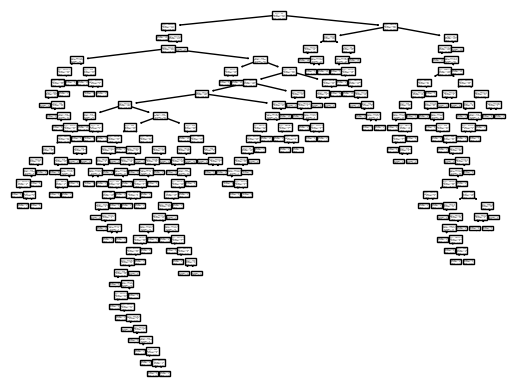

In [44]:
from sklearn import tree

tree.plot_tree(model_skl)